# Modelos para a classificação de diabetes


É importante ressaltar que os dados do Vigitel não devem ser analisados no Excel, do pacote Office (ou programa semelhante), pois a amostra do Vigitel leva em consideração fatores de ponderação para a análise de dados.

É necessário o uso de programas como o Epi Info ou R, ou, ainda, Stata, SPSS, SAS, entre outros, que possuem módulos de análise específicos para a utilização de fatores de ponderação

Link da base: https://svs.aids.gov.br/download/Vigitel/

trabalho relacionado que usou vigitel: https://www.scielo.br/j/ress/a/6hn69ts9c5mkPjHcGBMBbGJ/?lang=pt

referências:
artigo que usa métodos de ml para prever diabetico ou não
https://www.mdpi.com/1424-8220/22/16/6155

# Tratamento de dados

#### Bibliotecas e setar diretório

rodar e reiniciar..

In [1]:
try:
  import dython
  from dython.nominal import associations
except:
  ! pip install dython
  import dython
  from dython.nominal import associations

In [2]:
import xgboost as xgb
import multiprocessing

In [3]:
# !pip uninstall shap
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 83.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.0
    Uninstalling numpy-1.25.0:
      Successfully uninstalled numpy-1.25.0


In [4]:
# !kill -9 -1

In [5]:

# import pkg_resources
# # pkg_resources.require("numpy== 1.22.4")
# import numpy as np
# !pip show numpy

# import dython
# from dython.nominal import associations

In [6]:
import pandas as pd
pd.set_option('display.max_columns', 250)
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np

In [7]:

from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, balanced_accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#### Import de dados

In [9]:
# read file from google drive at folder databetes
# file_path = 'drive/My Drive/databetes/Vigitel-2021-peso-rake.xls'
# file_path = 'drive/My Drive/databetes/Vigitel-2020-peso-rake.xls'
file_path = 'drive/My Drive/databetes/data/processed/df_tratado.csv'
# file_path = '../data/Vigitel-2019-peso-rake.xls'
# df = pd.read_excel(file_path, sheet_name='Sheet1')
df = pd.read_csv(file_path)

In [10]:
file_path = 'drive/My Drive/databetes/data/processed/df_train.csv'
# file_path = '../data/Vigitel-2019-peso-rake.xls'
# df = pd.read_excel(file_path, sheet_name='Sheet1')
df_train = pd.read_csv(file_path)

In [11]:
file_path = 'drive/My Drive/databetes/data/processed/df_val.csv'
# file_path = '../data/Vigitel-2019-peso-rake.xls'
# df = pd.read_excel(file_path, sheet_name='Sheet1')
df_val = pd.read_csv(file_path)

In [12]:
file_path = 'drive/My Drive/databetes/data/processed/df_test.csv'
# file_path = '../data/Vigitel-2019-peso-rake.xls'
# df = pd.read_excel(file_path, sheet_name='Sheet1')
df_test = pd.read_csv(file_path)

In [13]:
def preprocess_subset(df):
  rename_cols_dict = {
                            'q6':'idade (anos)',
                            'classe imc': 'classe_imc',
                            'grau escolaridade':'grau_escolaridade',
                            'bebida alcoólica':'bebida_alcoolica',
                            'freq alcool':'freq_alcool',
                            'exercício físico':'exercicio_fisico',
                            'q45':'freq_exercicio',
                            'pressão alta':'pressao_alta',
                            'faixa etária (anos)':'faixa_etaria'
                                }

  df = df.rename(columns=rename_cols_dict)
  df_model = df[['imc','pressao_alta','grau_escolaridade','bebida_alcoolica','exercicio_fisico','freq_alcool','faixa_etaria','diabetes']]
  # Mapear os valores categóricos - 0 não bebe 7 bebe todos os dias
  mapping = {
      float('nan'):0 ,
      '1 a 2 dias por semana': 2,
      '3 a 4 dias por semana': 4,
      'menos de 1 dia por semana': 2,
      'todos os dias (inclusive sábado e domingo)': 7,
      'menos de 1 dia por mês': 1,
      '5 a 6 dias por semana': 5,
      '6 a 7 dias por semana': 6
  }

  # Adicionar a nova coluna
  df_model['cat_alcool'] = df_model['freq_alcool'].map(mapping)
  df_model = df_model.drop(columns=['bebida_alcoolica','freq_alcool'])
  def one_hot_encode(df,cols):
    # checar se são todos uniques
    # for col in cols:
      # display(df[col].unique())
    df = pd.get_dummies(data=df, columns=cols)
    display(df)
    return df

  # df_model = one_hot_encode(df_model,cols=['pressao_alta','exercicio_fisico','grau_escolaridade','bebida_alcoolica','faixa_etaria'])
  #convertendo a categoria de alcool em categorica
  df_model = one_hot_encode(df_model,cols=['pressao_alta','exercicio_fisico','grau_escolaridade','cat_alcool','faixa_etaria'])

  df_model['diabetes'] = df_model['diabetes'].map({'não':0,
                                                              'sim':1
                                                              })
  return df_model

In [14]:
df_train = preprocess_subset(df_train)
df_train

<ipython-input-13-3e54bcb9ed0c>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['cat_alcool'] = df_model['freq_alcool'].map(mapping)


,imc,diabetes,pressao_alta_não,pressao_alta_sim,exercicio_fisico_não,exercicio_fisico_sim,grau_escolaridade_1º grau ou fundamental ou supletivo de 1º grau,grau_escolaridade_2º grau ou colégio ou técnico ou normal ou científico científico ou ensino médio ou supletivo de 2º grau,grau_escolaridade_3º grau ou curso superior,grau_escolaridade_admissão,grau_escolaridade_curso ginasial ou ginásio,grau_escolaridade_curso primário,grau_escolaridade_nunca estudou,"grau_escolaridade_pós-graduação (especialização, mestrado, doutorado)",cat_alcool_0,cat_alcool_1,cat_alcool_2,cat_alcool_4,cat_alcool_5,cat_alcool_7,faixa_etaria_18 a 24,faixa_etaria_25 a 34,faixa_etaria_35 a 44,faixa_etaria_45 a 54,faixa_etaria_55 a 64,faixa_etaria_65+
0,30.4,sim,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1,28.3,sim,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,23.2,sim,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
3,32.8,sim,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
4,21.5,sim,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106756,28.3,não,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
106757,32.7,não,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
106758,33.7,não,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
106759,23.6,não,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


,imc,diabetes,pressao_alta_não,pressao_alta_sim,exercicio_fisico_não,exercicio_fisico_sim,grau_escolaridade_1º grau ou fundamental ou supletivo de 1º grau,grau_escolaridade_2º grau ou colégio ou técnico ou normal ou científico científico ou ensino médio ou supletivo de 2º grau,grau_escolaridade_3º grau ou curso superior,grau_escolaridade_admissão,grau_escolaridade_curso ginasial ou ginásio,grau_escolaridade_curso primário,grau_escolaridade_nunca estudou,"grau_escolaridade_pós-graduação (especialização, mestrado, doutorado)",cat_alcool_0,cat_alcool_1,cat_alcool_2,cat_alcool_4,cat_alcool_5,cat_alcool_7,faixa_etaria_18 a 24,faixa_etaria_25 a 34,faixa_etaria_35 a 44,faixa_etaria_45 a 54,faixa_etaria_55 a 64,faixa_etaria_65+
0,30.4,1,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1,28.3,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,23.2,1,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
3,32.8,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
4,21.5,1,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106756,28.3,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
106757,32.7,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
106758,33.7,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
106759,23.6,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


In [15]:
df_val = preprocess_subset(df_val)
df_val

<ipython-input-13-3e54bcb9ed0c>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['cat_alcool'] = df_model['freq_alcool'].map(mapping)


,imc,diabetes,pressao_alta_não,pressao_alta_sim,exercicio_fisico_não,exercicio_fisico_sim,grau_escolaridade_1º grau ou fundamental ou supletivo de 1º grau,grau_escolaridade_2º grau ou colégio ou técnico ou normal ou científico científico ou ensino médio ou supletivo de 2º grau,grau_escolaridade_3º grau ou curso superior,grau_escolaridade_admissão,grau_escolaridade_curso ginasial ou ginásio,grau_escolaridade_curso primário,grau_escolaridade_nunca estudou,"grau_escolaridade_pós-graduação (especialização, mestrado, doutorado)",cat_alcool_0,cat_alcool_1,cat_alcool_2,cat_alcool_4,cat_alcool_5,cat_alcool_7,faixa_etaria_18 a 24,faixa_etaria_25 a 34,faixa_etaria_35 a 44,faixa_etaria_45 a 54,faixa_etaria_55 a 64,faixa_etaria_65+
0,33.8,sim,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1,28.4,sim,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,25.2,sim,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
3,24.8,sim,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
4,25.4,sim,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38102,23.3,não,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
38103,27.1,não,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
38104,22.5,não,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
38105,27.0,não,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


,imc,diabetes,pressao_alta_não,pressao_alta_sim,exercicio_fisico_não,exercicio_fisico_sim,grau_escolaridade_1º grau ou fundamental ou supletivo de 1º grau,grau_escolaridade_2º grau ou colégio ou técnico ou normal ou científico científico ou ensino médio ou supletivo de 2º grau,grau_escolaridade_3º grau ou curso superior,grau_escolaridade_admissão,grau_escolaridade_curso ginasial ou ginásio,grau_escolaridade_curso primário,grau_escolaridade_nunca estudou,"grau_escolaridade_pós-graduação (especialização, mestrado, doutorado)",cat_alcool_0,cat_alcool_1,cat_alcool_2,cat_alcool_4,cat_alcool_5,cat_alcool_7,faixa_etaria_18 a 24,faixa_etaria_25 a 34,faixa_etaria_35 a 44,faixa_etaria_45 a 54,faixa_etaria_55 a 64,faixa_etaria_65+
0,33.8,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1,28.4,1,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,25.2,1,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
3,24.8,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
4,25.4,1,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38102,23.3,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
38103,27.1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
38104,22.5,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
38105,27.0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


In [16]:
df

,chave,replica,ano,cidade,região,sexo,idade (anos),faixa etária (anos),grau escolaridade,pressão alta,bebida alcoólica,freq alcool,exercício físico,cor,peso (kg),altura (cm),imc,classe imc,freq horta,freq refrigerante,moradores,fumante,posse plano saúde,idade início diabetes,diabetes
0,1,1,2015,Aracajú,Nordeste,masculino,59,55 a 64,1º grau ou fundamental ou supletivo de 1º grau,não,não,NaN,não,branca,76.0,172.0,25.7,sobrepeso,todos os dias (inclusive sábado e domingo),nunca,3,não,não,NaN,não
1,2,1,2015,Aracajú,Nordeste,feminino,20,18 a 24,2º grau ou colégio ou técnico ou normal ou cie...,sim,não,NaN,não,parda,84.0,162.0,32.0,obesidade classe I,5 a 6 dias por semana,1 a 2 dias por semana,7,não,não,NaN,não
2,4,1,2015,Aracajú,Nordeste,feminino,32,25 a 34,"pós-graduação (especialização, mestrado, douto...",não,não,NaN,sim,preta,45.0,160.0,17.6,baixo peso,3 a 4 dias por semana,quase nunca,2,não,"sim, apenas um",NaN,não
3,5,1,2015,Aracajú,Nordeste,feminino,70,65+,2º grau ou colégio ou técnico ou normal ou cie...,sim,sim,1 a 2 dias por semana,sim,parda,62.0,153.0,26.5,sobrepeso,todos os dias (inclusive sábado e domingo),nunca,2,não,"sim, apenas um",NaN,não
4,7,1,2015,Curitiba,Sul,feminino,84,65+,curso primário,sim,não,NaN,não,branca,51.0,140.0,26.0,sobrepeso,todos os dias (inclusive sábado e domingo),nunca,1,não,"sim, apenas um",84.0,sim
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235425,72213241096,33,2021,São Paulo,Sudeste,feminino,72,65+,3º grau ou curso superior,não,não,NaN,não,parda,44.0,153.0,18.8,adequado ou eutrófico,quase nunca,nunca,2,não,não,NaN,não
235426,45314403046,26,2021,Belo Horizonte,Sudeste,feminino,67,65+,"pós-graduação (especialização, mestrado, douto...",sim,sim,1 a 2 dias por semana,não,parda,64.0,156.0,26.3,sobrepeso,todos os dias (inclusive sábado e domingo),quase nunca,6,não,"sim, mais de um",NaN,não
235427,26374242025,4,2021,Vitória,Sudeste,feminino,75,65+,3º grau ou curso superior,não,sim,menos de 1 dia por semana,não,parda,60.0,147.0,27.8,sobrepeso,todos os dias (inclusive sábado e domingo),quase nunca,4,não,"sim, apenas um",NaN,não
235428,22312495026,36,2021,Porto Alegre,Sul,feminino,77,65+,"pós-graduação (especialização, mestrado, douto...",sim,não,NaN,não,preta,58.0,162.0,22.1,adequado ou eutrófico,todos os dias (inclusive sábado e domingo),nunca,1,não,não,NaN,não


Contagem de dados nulos

In [17]:
nas_count = df.isna().sum()[df.isna().sum()>0]
nas_count = nas_count.sort_values()

In [18]:
nas_count

freq alcool              143036
idade início diabetes    215929
dtype: int64

In [19]:
diabetes_count = df['diabetes'].value_counts()
diabetes_count

não    212432
sim     22998
Name: diabetes, dtype: int64

In [20]:
a

NameError: ignored

## Subset para as variáveis selecionadas

faixa etária
escolaridade
IMC
pressão alta
frequência de consumo de álcool
cor
atividade física

todo checar se todos os nans correspondem a não

# Correlação

In [21]:
def correlogram(df, limiar,offset = 0.08):
    df_selec_corr = df.corr(method='pearson')
    limiar = limiar
    nr = df_selec_corr.shape[0]
    C = df_selec_corr.to_numpy()
    M = np.zeros((nr, nr))

    for i in range(nr):
        for j in range(nr):
            if abs(C[i, j]) >= abs(limiar) and i != j:
                M[i, j] = 1

    np.set_printoptions(threshold=np.inf)

    n = M.shape[0]
    plt.figure(figsize=(8, 8))
    plt.rcParams.update({'font.size': 8})
    plt.axis('off')
    axis = np.linspace(0, 2 * np.pi, n, endpoint=False)
    x, y = np.cos(axis), np.sin(axis)
    offset = offset  # Adjust the offset value as needed

    for i in range(n):
        for j in range(i + 1, n):
            if M[i, j] == 1:
                correlation = C[i, j]
                line_color = 'b' if correlation >= 0 else 'r'  # Use blue for positive correlation, red for negative correlation
                line_width = abs(correlation) * 2  # Scale line width based on correlation magnitude
                plt.plot((x[i], x[j]), (y[i], y[j]), color=line_color, linewidth=line_width)

    plt.scatter(x, y)

    for i, txt in enumerate(df_selec_corr.columns.values):
        if len(txt) > 10:
            txt = txt[:10] + '...' + txt[-10:]  # Truncate the string if it's longer than 10 characters
        if txt == 'diabetes':
            plt.annotate(txt, (x[i] , y[i]), weight='bold', ha='center', va='center')
        elif y[i] >= 0:
            if x[i] < 0:
                plt.annotate(txt, (x[i] - offset, y[i] + offset))  # Add negative offset for left top annotations
                plt.arrow(x[i], y[i] , -0.4*offset, 0.4*offset, color='black', width=0.005, head_width=0.03, head_length=0.03)
            else:
                plt.annotate(txt, (x[i] + offset, y[i] + offset))  # Add positive offset for right top annotations
                plt.arrow(x[i] , y[i] , 0.4*offset, 0.4*offset, color='black', width=0.005, head_width=0.03, head_length=0.03)
        else:
            if x[i] < 0:
                plt.annotate(txt, (x[i] - offset, y[i] - offset))  # Add negative offset for left bottom annotations
                plt.arrow(x[i] , y[i] , -0.4*offset, -0.4*offset, color='black', width=0.005, head_width=0.03, head_length=0.03)
            else:
                plt.annotate(txt, (x[i] + offset, y[i] - offset))  # Add positive offset for right bottom annotations
                plt.arrow(x[i], y[i], 0.4*offset, -0.4*offset, color='black', width=0.005, head_width=0.03, head_length=0.03)
    plt.show()

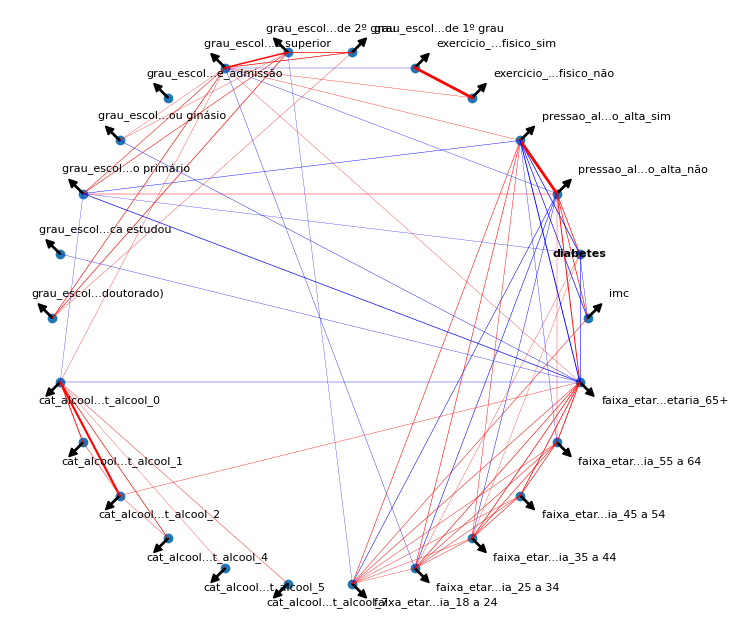

In [22]:
correlogram(df_train,limiar=0.1)

## Selecionando após correlograma

In [ ]:
# df_model = df_model[['imc','pressao_alta_sim','cat_alcool_7','grau_escolaridade_curso primário','faixa_etaria_65+','diabetes']]

# Modelagem

## Bibliotecas e funções

In [23]:
# model training
from sklearn import linear_model
# Check https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier
from sklearn.linear_model import SGDClassifier # Log losss for logistic regressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import OneClassSVM

# Metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve,roc_auc_score,auc
from sklearn.metrics import precision_recall_fscore_support
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import matthews_corrcoef, make_scorer
! pip -q install optuna
import optuna

from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn import tree
# tree.plot_tree(model.estimators_[0])

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.9 MB/s eta 0:00:00


In [24]:
def train_model(X_train, X_val, y_train, y_val, grid_search=False,trials=10,view_trees=False,model='baseline'):

    scaler = MinMaxScaler()
    normalized_train_X = scaler.fit_transform(X_train)

    X_train = normalized_train_X
    # normalize X validation
    normalized_X_val = scaler.fit_transform(X_val)
    X_val = normalized_X_val
    if grid_search:
      print("user chose to do gridsearch")
      def create_model(trial):

        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
            'max_depth': trial.suggest_int('max_depth', 4, 50),
            'min_samples_split': trial.suggest_int('min_samples_split', 1, 150),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 60),
        }

        model = RandomForestClassifier(random_state=SEED, **params)

        return model

      def objective(trial:optuna.trial.Trial):
          params = {
              'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
              'max_depth': trial.suggest_int('max_depth', 4, 50),
              'min_samples_split': trial.suggest_int('min_samples_split', 1, 150),
              'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 60),
          }

          model = create_model(trial)
          model.fit(normalized_train_X, y_train)
          y_pred = model.predict(X_val)
          score = balanced_accuracy_score(y_val, y_pred)
          return score


      study_rf = optuna.create_study(direction='maximize')
      study_rf.optimize(objective, n_trials=trials)

      fig = optuna.visualization.plot_optimization_history(study_rf)
      fig.show()

      # criação do modelo que performou melhor
      print("creating best model predictions")
      model = create_model(study_rf.best_trial)
      display(model)
      display(model.get_params())

      model.fit(normalized_train_X ,y_train)
      y_pred = model.predict(X_val)

    else:
      print("running models with no gridsearch")
      if model =='baseline':
        # baseline
        model = RandomForestClassifier(random_state=SEED,n_estimators= 500, max_depth=30, min_samples_leaf=5, n_jobs=-1)
      elif model =='tuned':
        # tunado sem SMOTE
        model = RandomForestClassifier(max_depth=46, n_estimators=842, random_state=SEED)
      elif model =='tunedsmote':
        # tunado com SMOTE
        model = RandomForestClassifier(max_depth=11, min_samples_leaf=34, min_samples_split=72,
                        n_estimators=160, random_state=SEED)
      elif model =='tunedadasys':
        params = {'bootstrap': True,
                  'ccp_alpha': 0.0,
                  'criterion': 'gini',
                  'max_depth': 8,
                  'max_features': 'sqrt',
                  'min_impurity_decrease': 0.0,
                  'min_samples_leaf': 1,
                  'min_samples_split': 146,
                  'min_weight_fraction_leaf': 0.0,
                  'n_estimators': 272,
                  'oob_score': False,
                  'verbose': 0,
                  'warm_start': False}
        model = RandomForestClassifier(random_state=SEED, **params)
      elif model == 'xgboost':
        xgb_model = xgb.XGBClassifier(n_jobs=multiprocessing.cpu_count() // 2)
        model = GridSearchCV(xgb_model, {'max_depth': [2, 4, 6],
                                      'n_estimators': [50, 100, 200]}, verbose=1,
                          n_jobs=2)
      else:
        print("specify model params")

      model.fit(X_train, y_train)

    y_pred = model.predict(X_val)

    try:
      y_pred_proba = model.predict_proba(X_val)[:, 1]
    except:

      y_pred_proba = y_pred
    return model, X_val,y_pred, y_val,y_pred_proba

In [25]:
def train_model_nn(X_train, X_val, y_train, y_val, grid_search=False,trials=5,view_trees=False,model='baseline'):

    scaler = MinMaxScaler()
    normalized_train_X = scaler.fit_transform(X_train)

    X_train = normalized_train_X
    # normalize X validation
    normalized_X_val = scaler.fit_transform(X_val)
    X_val = normalized_X_val
    if grid_search:
      print("user chose to do gridsearch")

      def create_model(trial):
        n_layers = trial.suggest_int('n_layers', 1, 10)
        layers = []
        for i in range(n_layers):
            layers.append(trial.suggest_int(f'n_units_{i}', 1, 100))

        model = MLPClassifier(solver='adam', alpha= trial.suggest_float("alpha", 1e-5,0.1, log=True),
                                    hidden_layer_sizes=tuple(layers),
                                    random_state=SEED, max_iter=10000)

        return model


      def objective(trial):
          params = {
              'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
              'max_depth': trial.suggest_int('max_depth', 4, 50),
              'min_samples_split': trial.suggest_int('min_samples_split', 1, 150),
              'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 60),
          }

          model = create_model(trial)
          model.fit(normalized_train_X, y_train)
          y_pred = model.predict(X_val)
          score = balanced_accuracy_score(y_val, y_pred)
          return score


      study_rf = optuna.create_study(direction='maximize')
      study_rf.optimize(objective, n_trials=trials)

      fig = optuna.visualization.plot_optimization_history(study_rf)
      fig.show()

      # criação do modelo que performou melhor
      print("creating best model predictions")
      model = create_model(study_rf.best_trial)
      display(model)
      display(model.get_params())

      model.fit(normalized_train_X ,y_train)
      y_pred = model.predict(X_val)

    else:
      print("running models with no gridsearch")
      # if model =='baseline':
      #   # baseline
      #   model = RandomForestClassifier(random_state=SEED,n_estimators= 500, max_depth=30, min_samples_leaf=5, n_jobs=-1)
      # elif model =='tuned':
      #   # tunado sem SMOTE
      #   model = RandomForestClassifier(max_depth=46, n_estimators=842, random_state=SEED)
      # elif model =='tunedsmote':
      #   # tunado com SMOTE
      #   model = RandomForestClassifier(max_depth=11, min_samples_leaf=34, min_samples_split=72,
      #                   n_estimators=160, random_state=SEED)
      # elif model =='tunedadasys':
      #   params = {'bootstrap': True,
      #             'ccp_alpha': 0.0,
      #             'criterion': 'gini',
      #             'max_depth': 8,
      #             'max_features': 'sqrt',
      #             'min_impurity_decrease': 0.0,
      #             'min_samples_leaf': 1,
      #             'min_samples_split': 146,
      #             'min_weight_fraction_leaf': 0.0,
      #             'n_estimators': 272,
      #             'oob_score': False,
      #             'verbose': 0,
      #             'warm_start': False}
      #   model = RandomForestClassifier(random_state=SEED, **params)
      # else:
      #   print("specify model params")

      model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1]

    return model, X_val,y_pred, y_val,y_pred_proba

In [26]:
def print_classification_report(y_val, y_val_pred,y_val_pred_proba=None,auc_metrics=True):
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_balanced_accuracy = balanced_accuracy_score(y_val, y_val_pred)
    print("Acurácia na validação: {:.2f}%".format(val_accuracy * 100))
    print("Acurácia balanceada na validação: {:.2f}%".format(val_balanced_accuracy * 100))

    # Gerando o relatório com diversas métricas
    report = classification_report(y_val, y_val_pred)

    # Exibindo o relatório
    print(report)


    # Plotando a matriz de confusão
    matriz_confusão = confusion_matrix(y_val, y_val_pred)
    sns.heatmap(matriz_confusão, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.show()
    plt.close()
    total1=sum(sum(matriz_confusão))
    #####from confusion matrix calculate accuracy
    # accuracy1=(matriz_confusão[0,0]+matriz_confusão[1,1])/total1
    # print ('Accuracy : ', accuracy1)
    sensitivity1 = matriz_confusão[0,0]/(matriz_confusão[0,0]+matriz_confusão[0,1])
    print('Sensitivity : ', sensitivity1 )

    specificity1 = matriz_confusão[1,1]/(matriz_confusão[1,0]+matriz_confusão[1,1])
    print('Specificity : ', specificity1)
    if auc_metrics == True:
      # Calculate False Positive Rate (FPR) and True Positive Rate (TPR)
      fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_proba)
      # Calculate AUC score
      auc = roc_auc_score(y_val, y_val_pred_proba)
      print(f'AUC = {auc} ')
      # Plot ROC curve
      plt.figure(figsize=(8, 6))
      plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
      plt.plot([0, 1], [0, 1], 'r--')
      plt.xlim([0, 1])
      plt.ylim([0, 1])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('Receiver Operating Characteristic (ROC) Curve')
      plt.legend(loc='lower right')
      plt.show()
      plt.close()


## Divisão em X e y

In [27]:
X_train =  df_train.drop('diabetes', axis=1)

y_train = df_train['diabetes']

In [28]:
X_train

,imc,pressao_alta_não,pressao_alta_sim,exercicio_fisico_não,exercicio_fisico_sim,grau_escolaridade_1º grau ou fundamental ou supletivo de 1º grau,grau_escolaridade_2º grau ou colégio ou técnico ou normal ou científico científico ou ensino médio ou supletivo de 2º grau,grau_escolaridade_3º grau ou curso superior,grau_escolaridade_admissão,grau_escolaridade_curso ginasial ou ginásio,grau_escolaridade_curso primário,grau_escolaridade_nunca estudou,"grau_escolaridade_pós-graduação (especialização, mestrado, doutorado)",cat_alcool_0,cat_alcool_1,cat_alcool_2,cat_alcool_4,cat_alcool_5,cat_alcool_7,faixa_etaria_18 a 24,faixa_etaria_25 a 34,faixa_etaria_35 a 44,faixa_etaria_45 a 54,faixa_etaria_55 a 64,faixa_etaria_65+
0,30.4,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1,28.3,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,23.2,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
3,32.8,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
4,21.5,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106756,28.3,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
106757,32.7,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
106758,33.7,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
106759,23.6,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
# y_train = pd.DataFrame(y_train)

In [29]:
X_val =  df_val.drop('diabetes', axis=1)

y_val = df_val['diabetes']

In [ ]:
# y_val = pd.DataFrame(y_val)

In [30]:
y_val

0        1
1        1
2        1
3        1
4        1
        ..
38102    0
38103    0
38104    0
38105    0
38106    0
Name: diabetes, Length: 38107, dtype: int64

In [31]:
y_train

0         1
1         1
2         1
3         1
4         1
         ..
106756    0
106757    0
106758    0
106759    0
106760    0
Name: diabetes, Length: 106761, dtype: int64

## Referência métricas

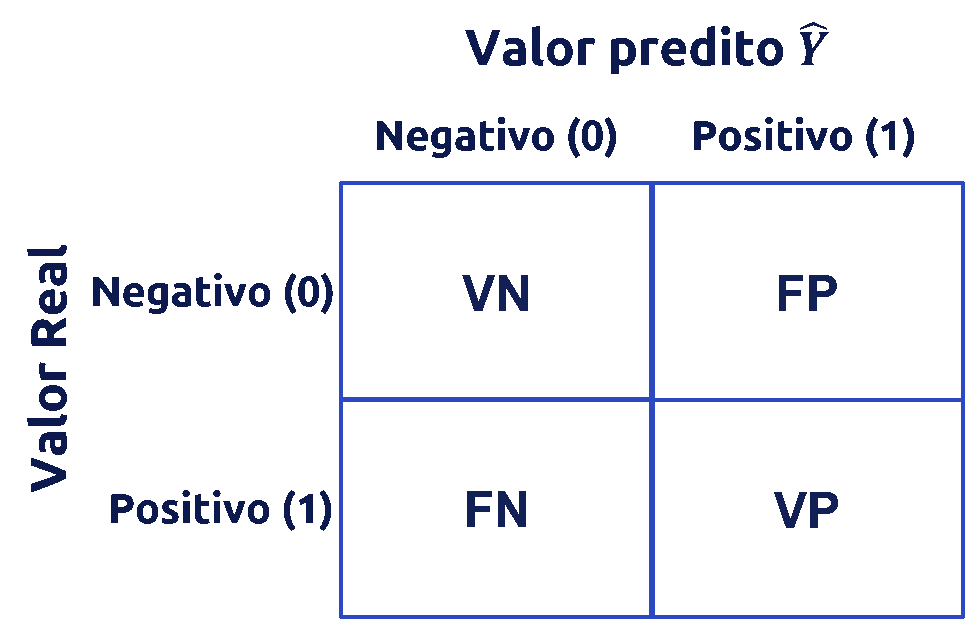![image.png]()

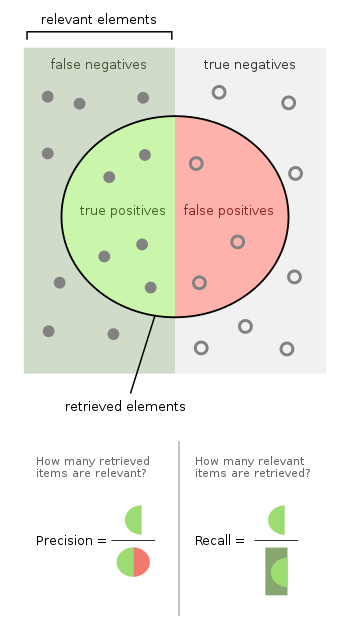

quais dados ele errou?

In [ ]:
# column_names = ['imc','pressao_alta_sim','cat_alcool_7','grau_escolaridade_curso primário','faixa_etaria_65+']

In [ ]:
# df_wrong = X_val[y_val != y_pred]

In [ ]:

# df_wrong = pd.DataFrame(df_wrong, columns=column_names)

In [ ]:
# df_wrong

In [ ]:
# # Função para criar boxplots em subplots com 2 linhas e 5 colunas
# def create_histograms_subplots(df):
#     # Determinar o número de colunas e linhas dos subplots
#     num_cols = 5
#     num_rows = 1

#     # Determinar o tamanho total da figura
#     figsize = (15, 6)

#     # Criar a figura e os subplots
#     fig, axs = plt.subplots(num_rows, num_cols, figsize=figsize)

#     # Redimensionar o array de subplots
#     axs = axs.flatten()

#     # Iterar sobre cada coluna do dataframe
#     for i, column in enumerate(df.columns):
#         # Criar o histograma para a coluna atual
#         axs[i].hist(df[column])
#         axs[i].set_xlabel('Valor')
#         axs[i].set_ylabel('Frequência')
#         axs[i].set_title(f'Histograma para {column}')

#     # Ajustar o espaçamento entre os subplots
#     plt.tight_layout()

#     # Exibir a figura
#     plt.show()

# # Chamar a função para criar os boxplots separados
# create_histograms_subplots(df_wrong)

In [ ]:
# #preveu diabetes e não é - false positive
# df_fp = X_val[(y_val == 0) & (y_pred== 1)]

# df_fp = pd.DataFrame(df_fp, columns=column_names)
# display(df_fp)
# create_histograms_subplots(df_fp)

In [ ]:
# #preveu sem diabetes e não é - false negative
# df_fn = X_val[(y_val == 1) & (y_pred== 0)]

# df_fn = pd.DataFrame(df_fn, columns=column_names)
# display(df_fn)
# create_histograms_subplots(df_fn)

Predizeu que pessoas não eram diabéticas, quando eram. Faremos o balanceamento dos dados utilizando o SMOTE.

# Balanceamento dos dados

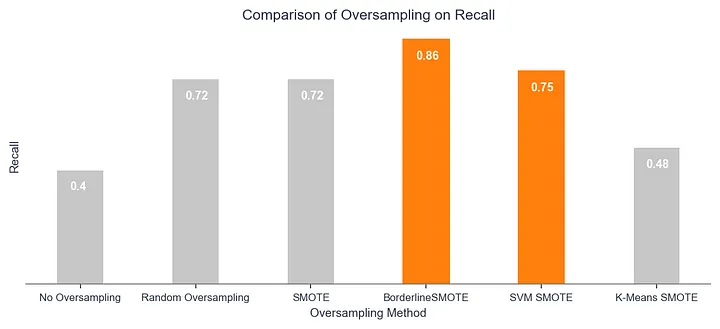

Fonte: https://medium.com/analytics-vidhya/handling-imbalanced-data-by-oversampling-with-smote-and-its-variants-23a4bf188eaf

## SMOTE

O SMOTE é uma técnica de aumentação de dados deve ser aplicada depois de dividir os dados em conjuntos de treinamento e teste. É importante evitar qualquer vazamento de informações do conjunto de teste para o conjunto de treinamento durante o processo de reamostragem

como o smote funciona? https://medium.com/coinmonks/smote-and-adasyn-handling-imbalanced-data-set-34f5223e167

Goal: Increase the minority class so that the data set becomes balanced by creating synthetic observations based upon the existing minority observations.

SMOTE:

What smote does is simple. First it finds the n-nearest neighbors in the minority class for each of the samples in the class . Then it draws a line between the the neighbors an generates random points on the lines.

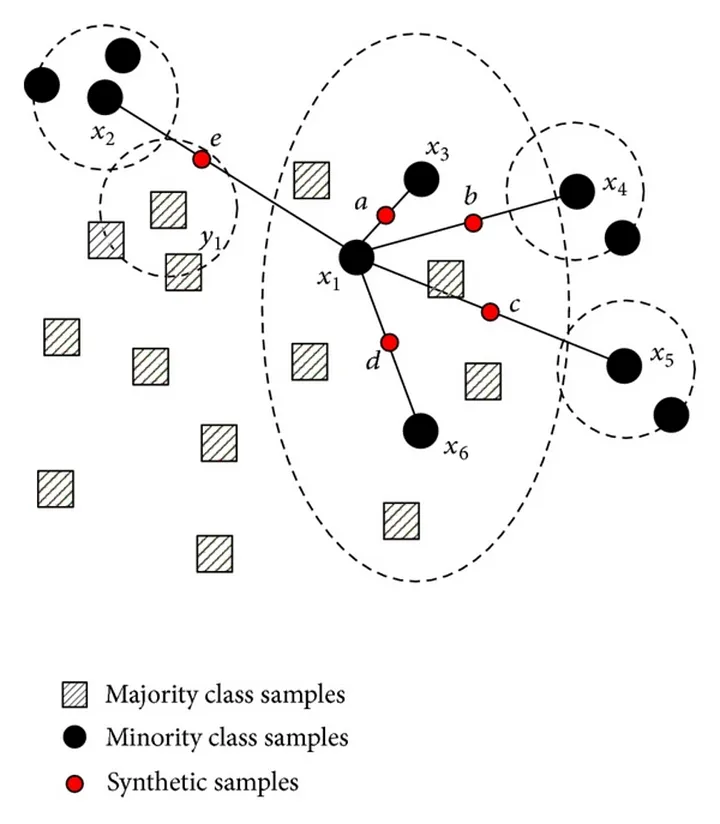

Select a sample, let’s call it O (for Origin), from the minority class randomly

Find the K-Nearest Neighbours of O that belong to the same class

Connect O to each of these neighbours using a straight line

Select a scaling factor ‘z’ in the range [0,1] randomly

For each new connection, place a new point on the line (z*100)% away from O. These will be our synthetic samples.

Repeat this process until you get the desired number of synthetic samples

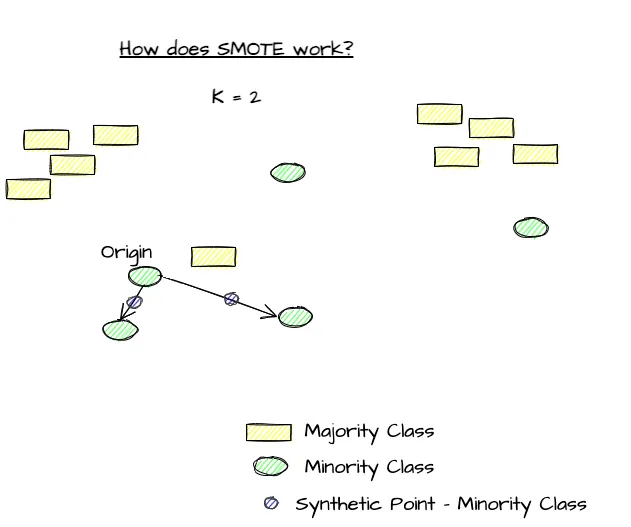

In [ ]:
# X =  df_model.drop('diabetes', axis=1)
# y = df_model['diabetes']

In [ ]:
# train_ratio = 0.7
# validation_ratio = 0.15
# test_ratio = 0.15

# # train é 75% do dataset
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state=SEED, shuffle=True)

# # test é 15% do dataset inicial
# # validation é 15% do dataset inicial
# X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=SEED, shuffle=True)

## novo

In [34]:
SEED = 21

In [32]:
X_train =  df_train.drop('diabetes', axis=1)

y_train = df_train['diabetes']

In [33]:
X_val =  df_val.drop('diabetes', axis=1)

y_val = df_val['diabetes']

In [35]:
smote = SMOTE(random_state=SEED)
# Upsample the minority class using SMOTE
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print("Distribuição de diabéticos antes do SMOTE:")
print(y_train.value_counts())

print("Distribuição de diabéticos depois do SMOTE:")
print(y_resampled.value_counts())

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7f324efaa4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 584, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 725, in _make_controller_from_path
    lib_controller = lib_controller_class(
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 842, in __init__
    super().__init__(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 810, in __init__
    self._dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /usr/local/lib/python3.10/dist-packages/numpy.libs/libopenblas64_p-r0-7a851222.3.23.so: cannot ope

Distribuição de diabéticos antes do SMOTE:
0    96129
1    10632
Name: diabetes, dtype: int64
Distribuição de diabéticos depois do SMOTE:
1    96129
0    96129
Name: diabetes, dtype: int64


In [ ]:
# Perform PCA for dimensionality reduction and visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
X_resampled_pca = pca.transform(X_resampled)

# Plot the data before and after SMOTE
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='bwr', alpha=0.7)
plt.title('Dados antes do SMOTE')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(handles=[plt.Line2D([], [], color='blue', marker='o', linestyle='None', alpha=0.7, label='Sem diabetes'),
                    plt.Line2D([], [], color='red', marker='o', linestyle='None', alpha=0.7, label='Com diabetes')])

plt.subplot(1, 2, 2)
plt.scatter(X_resampled_pca[:, 0], X_resampled_pca[:, 1], c=y_resampled, cmap='bwr', alpha=0.7)
plt.title('Dados depois do SMOTE')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(handles=[plt.Line2D([], [], color='blue', marker='o', linestyle='None', alpha=0.7, label='Sem diabetes'),
                    plt.Line2D([], [], color='red', marker='o', linestyle='None', alpha=0.7, label='Com diabetes')])

plt.tight_layout()
plt.show()

In [36]:
# x agora é o resampled
X_train= X_resampled.copy()
y_train = y_resampled.copy()

In [37]:
model, X_val,y_pred, y_val,y_pred_proba = train_model(X_train, X_val, y_train, y_val,grid_search =False,model='tunedsmote')

running models with no gridsearch


In [40]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283839 sha256=befd33f73e73301f7ef0fdfbe66a0b48e22f88bbe32540f8d6509321298909ae
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [41]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
import optuna
import optuna.visualization
import lime
import lime.lime_tabular

def train_model_with_lime(X_train, X_val, y_train, y_val, grid_search=False, trials=10, view_trees=False, model='baseline'):
    scaler = MinMaxScaler()
    normalized_train_X = scaler.fit_transform(X_train)
    X_train = normalized_train_X

    # normalize X validation
    normalized_X_val = scaler.transform(X_val)
    X_val = normalized_X_val

    if grid_search:
        print("User chose to do gridsearch")
        def create_model(trial):
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
                'max_depth': trial.suggest_int('max_depth', 4, 50),
                'min_samples_split': trial.suggest_int('min_samples_split', 1, 150),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 60),
            }
            model = RandomForestClassifier(random_state=SEED, **params)
            return model

        def objective(trial: optuna.trial.Trial):
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
                'max_depth': trial.suggest_int('max_depth', 4, 50),
                'min_samples_split': trial.suggest_int('min_samples_split', 1, 150),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 60),
            }
            model = create_model(trial)
            model.fit(normalized_train_X, y_train)
            y_pred = model.predict(X_val)
            score = balanced_accuracy_score(y_val, y_pred)
            return score

        study_rf = optuna.create_study(direction='maximize')
        study_rf.optimize(objective, n_trials=trials)

        fig = optuna.visualization.plot_optimization_history(study_rf)
        fig.show()

        # Create the best performing model
        print("Creating the best model predictions")
        model = create_model(study_rf.best_trial)
        display(model)
        display(model.get_params())

        model.fit(normalized_train_X, y_train)
        y_pred = model.predict(X_val)
    else:
        print("Running models with no gridsearch")
        if model == 'baseline':
            # Baseline
            model = RandomForestClassifier(random_state=SEED, n_estimators=500, max_depth=30, min_samples_leaf=5,
                                           n_jobs=-1)
        elif model == 'tuned':
            # Tuned without SMOTE
            model = RandomForestClassifier(max_depth=46, n_estimators=842, random_state=SEED)
        elif model == 'tunedsmote':
            # Tuned with SMOTE
            model = RandomForestClassifier(max_depth=11, min_samples_leaf=34, min_samples_split=72,
                                           n_estimators=160, random_state=SEED)
        elif model == 'tunedadasys':
            params = {'bootstrap': True,
                      'ccp_alpha': 0.0,
                      'criterion': 'gini',
                      'max_depth': 8,
                      'max_features': 'sqrt',
                      'min_impurity_decrease': 0.0,
                      'min_samples_leaf': 1,
                      'min_samples_split': 146,
                      'min_weight_fraction_leaf': 0.0,
                      'n_estimators': 272,
                      'oob_score': False,
                      'verbose': 0,
                      'warm_start': False}
            model = RandomForestClassifier(random_state=SEED, **params)
        elif model == 'xgboost':
            xgb_model = xgb.XGBClassifier(n_jobs=multiprocessing.cpu_count() // 2)
            model = GridSearchCV(xgb_model, {'max_depth': [2, 4, 6],
                                             'n_estimators': [50, 100, 200]}, verbose=1,
                                 n_jobs=2)
        else:
            print("Specify model params")

        model.fit(X_train, y_train)

    y_pred = model.predict(X_val)

    try:
        y_pred_proba = model.predict_proba(X_val)[:, 1]
    except:
        y_pred_proba = y_pred

    # Lime explanation
    df_lime = df_train.drop('diabetes', axis=1)
    explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=list(df_lime.columns),
                                                       class_names=['0', '1'], discretize_continuous=True)
    # explanation = explainer.explain_instance(X_val[0], model.predict_proba, num_features=len(df_train.columns))

    return model, X_val, y_pred, y_val, y_pred_proba, explainer


In [42]:
model, X_val,y_pred, y_val,y_pred_proba,explainer = train_model_with_lime(X_train, X_val, y_train, y_val,grid_search =False,model='tunedsmote')

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Running models with no gridsearch


In [43]:
# Lime explanation
# explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=list(df_train.columns),
#                                                     class_names=['0', '1'], discretize_continuous=True)
explanation = explainer.explain_instance(X_val[15], model.predict_proba, num_features=len(df_train.columns))

In [44]:
print(df_val.columns)
X_val[15]


Index(['imc', 'diabetes', 'pressao_alta_não', 'pressao_alta_sim',
       'exercicio_fisico_não', 'exercicio_fisico_sim',
       'grau_escolaridade_1º grau ou fundamental ou supletivo de 1º grau',
       'grau_escolaridade_2º grau ou colégio ou técnico ou normal ou científico científico ou ensino médio ou supletivo de 2º grau',
       'grau_escolaridade_3º grau ou curso superior',
       'grau_escolaridade_admissão',
       'grau_escolaridade_curso ginasial ou ginásio',
       'grau_escolaridade_curso primário', 'grau_escolaridade_nunca estudou',
       'grau_escolaridade_pós-graduação (especialização, mestrado, doutorado)',
       'cat_alcool_0', 'cat_alcool_1', 'cat_alcool_2', 'cat_alcool_4',
       'cat_alcool_5', 'cat_alcool_7', 'faixa_etaria_18 a 24',
       'faixa_etaria_25 a 34', 'faixa_etaria_35 a 44', 'faixa_etaria_45 a 54',
       'faixa_etaria_55 a 64', 'faixa_etaria_65+'],
      dtype='object')


array([-0.7082334,  0.       ,  1.       ,  0.       ,  1.       ,
        0.       ,  0.       ,  1.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  1.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  1.       ,  0.       ,  0.       ])

pessoas diabéticas, análise de performance

In [45]:
for i in range(15,20):

  print(f'mostrando valores para a pessoa {i} ')
  if y_val[i]==y_pred[i]:
    print(f"modelo acertou, preveu {y_pred[i]} e era {y_val[i]}")
  else:
    print(f"modelo errou, preveu {y_pred[i]} e era {y_val[i]}")
  df = pd.DataFrame([X_val[i]], columns=df_val.drop('diabetes', axis=1).columns)
  df['diabetes_real']=y_val[i]
  df['diabetes_predito']=y_pred[i]
  display(df)
  explanation = explainer.explain_instance(X_val[i], model.predict_proba, num_features=len(df_train.columns))
  explanation.show_in_notebook(show_table=True)


Output hidden; open in https://colab.research.google.com to view.

pessoas não diabéticas

In [ ]:
for i in range(5000,5005):

  print(f'mostrando valores para a pessoa {i} ')
  if y_val[i]==y_pred[i]:
    print(f"modelo acertou, preveu {y_pred[i]} e era {y_val[i]}")
  else:
    print(f"modelo errou, preveu {y_pred[i]} e era {y_val[i]}")
  df = pd.DataFrame([X_val[i]], columns=df_val.drop('diabetes', axis=1).columns)
  df['diabetes_real']=y_val[i]
  df['diabetes_predito']=y_pred[i]
  display(df)
  explanation = explainer.explain_instance(X_val[i], model.predict_proba, num_features=len(df_train.columns))
  explanation.show_in_notebook(show_table=True)

In [ ]:
explanation.show_in_notebook(show_table=True)

In [ ]:
explanation.as_list()

In [ ]:
# Get the explanation for the first instance in X_val
instance_idx = 0
exp = explanation.as_list(1)

# Plot the explanation
labels = [x[0] for x in exp]
weights = [x[1] for x in exp]

plt.barh(labels, weights)
plt.xlabel('Feature Weight')
plt.ylabel('Feature')
plt.title('Lime Explanation')
plt.show()

In [ ]:
explanation.show_in_notebook(show_table=True)

testando agregar cada um do modelo

In [55]:
from pprint import pprint
l =[]
for i in range(15,17):

  print(f'mostrando valores para a pessoa {i} ')
  if y_val[i]==y_pred[i]:
    print(f"modelo acertou, preveu {y_pred[i]} e era {y_val[i]}")
  else:
    print(f"modelo errou, preveu {y_pred[i]} e era {y_val[i]}")
  df = pd.DataFrame([X_val[i]], columns=df_val.drop('diabetes', axis=1).columns)
  df['diabetes_real']=y_val[i]
  df['diabetes_predito']=y_pred[i]
  display(df)

  # exp = explainer.explain_instance(X_val[i],top_labels= 2,num_features=5)
  # print(exp)
  explanation = explainer.explain_instance(X_val[i], model.predict_proba, num_features=len(df_train.columns))
  # Extract feature names and importance scores from the explanation object
  # feature_names = explanation.feature_names()
  # importance_scores = explanation.feature_importances_

  # Create a dataframe from the feature names and importance scores
  # df_explanation = pd.DataFrame({'Feature': feature_names, 'Importance': importance_scores})

  # Print the dataframe
  # display(df_explanation)
  # pprint(explanation,type(explanation))
  a=explanation.as_list()
  l.append(a)
  explanation.show_in_notebook(show_table=True)


Output hidden; open in https://colab.research.google.com to view.

In [96]:
print(l[i])
df_lime = df_train.drop('diabetes', axis=1)
df_lime.columns

[('faixa_etaria_25 a 34 <= 0.00', 0.31685320003963785), ('faixa_etaria_18 a 24 <= 0.00', 0.2952871160609174), ('faixa_etaria_35 a 44 <= 0.00', 0.21001772117414677), ('pressao_alta_não <= 0.00', 0.18738187822399463), ('cat_alcool_7 <= 0.00', 0.11246262500534572), ('imc <= 0.27', -0.08283832425395259), ('cat_alcool_4 <= 0.00', 0.08160797290463663), ('faixa_etaria_65+ <= 0.00', -0.07658561128979151), ('faixa_etaria_45 a 54 <= 0.00', 0.06724125427007863), ('grau_escolaridade_pós-graduação (especialização, mestrado, doutorado) <= 0.00', 0.05078903609752641), ('cat_alcool_1 <= 0.00', 0.050380617967473604), ('cat_alcool_2 <= 0.00', 0.03838489126974127), ('exercicio_fisico_sim <= 0.00', 0.02889398688060856), ('grau_escolaridade_3º grau ou curso superior <= 0.00', 0.02780560660492784), ('0.00 < pressao_alta_sim <= 1.00', 0.025485562483980595), ('cat_alcool_5 <= 0.00', 0.0180464119484932), ('grau_escolaridade_curso ginasial ou ginásio <= 0.00', 0.0071315426567980815), ('0.00 < exercicio_fisico_n

Index(['imc', 'pressao_alta_não', 'pressao_alta_sim', 'exercicio_fisico_não',
       'exercicio_fisico_sim',
       'grau_escolaridade_1º grau ou fundamental ou supletivo de 1º grau',
       'grau_escolaridade_2º grau ou colégio ou técnico ou normal ou científico científico ou ensino médio ou supletivo de 2º grau',
       'grau_escolaridade_3º grau ou curso superior',
       'grau_escolaridade_admissão',
       'grau_escolaridade_curso ginasial ou ginásio',
       'grau_escolaridade_curso primário', 'grau_escolaridade_nunca estudou',
       'grau_escolaridade_pós-graduação (especialização, mestrado, doutorado)',
       'cat_alcool_0', 'cat_alcool_1', 'cat_alcool_2', 'cat_alcool_4',
       'cat_alcool_5', 'cat_alcool_7', 'faixa_etaria_18 a 24',
       'faixa_etaria_25 a 34', 'faixa_etaria_35 a 44', 'faixa_etaria_45 a 54',
       'faixa_etaria_55 a 64', 'faixa_etaria_65+'],
      dtype='object')

In [113]:

values = []
df_explanations = pd.DataFrame(columns=df_lime.columns)
expp = []
for i in range(len(l)):

  # print(l[i])
  for f in range(len(l[i])):
    features = []
    feature_ = l[i][f][0]
    value = l[i][f][1]
    features.append(feature_)
    values.append(value)
    print(values)
    expp.append(values)
    # df_explanations[feature_].iloc[i] = feature_
# df_explanations
df_componentes = pd.DataFrame(expp)#,columns=df_lime.columns)
display(df_componentes)
print(features,values)

[0.32535458139910267]
[0.32535458139910267, 0.2962801269310465]
[0.32535458139910267, 0.2962801269310465, 0.2069340539506933]
[0.32535458139910267, 0.2962801269310465, 0.2069340539506933, 0.1860351327727996]
[0.32535458139910267, 0.2962801269310465, 0.2069340539506933, 0.1860351327727996, 0.091580857213499]
[0.32535458139910267, 0.2962801269310465, 0.2069340539506933, 0.1860351327727996, 0.091580857213499, -0.0848406279908479]
[0.32535458139910267, 0.2962801269310465, 0.2069340539506933, 0.1860351327727996, 0.091580857213499, -0.0848406279908479, -0.08040209572618533]
[0.32535458139910267, 0.2962801269310465, 0.2069340539506933, 0.1860351327727996, 0.091580857213499, -0.0848406279908479, -0.08040209572618533, 0.07422546501463362]
[0.32535458139910267, 0.2962801269310465, 0.2069340539506933, 0.1860351327727996, 0.091580857213499, -0.0848406279908479, -0.08040209572618533, 0.07422546501463362, -0.06729743466862348]
[0.32535458139910267, 0.2962801269310465, 0.2069340539506933, 0.186035132

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,0.325355,0.29628,0.206934,0.186035,0.091581,-0.084841,-0.080402,0.074225,-0.067297,0.05171,0.046118,0.045777,0.034929,-0.031059,-0.029208,0.021785,0.020901,-0.011433,-0.007619,0.006541,-0.003576,-0.003566,0.002984,0.002256,0.001184,0.316853,0.295287,0.210018,0.187382,0.112463,-0.082838,0.081608,-0.076586,0.067241,0.050789,0.050381,0.038385,0.028894,0.027806,0.025486,0.018046,0.007132,-0.006875,0.006787,0.005923,-0.004581,0.004372,-0.004322,0.004198,0.002145
1,0.325355,0.29628,0.206934,0.186035,0.091581,-0.084841,-0.080402,0.074225,-0.067297,0.05171,0.046118,0.045777,0.034929,-0.031059,-0.029208,0.021785,0.020901,-0.011433,-0.007619,0.006541,-0.003576,-0.003566,0.002984,0.002256,0.001184,0.316853,0.295287,0.210018,0.187382,0.112463,-0.082838,0.081608,-0.076586,0.067241,0.050789,0.050381,0.038385,0.028894,0.027806,0.025486,0.018046,0.007132,-0.006875,0.006787,0.005923,-0.004581,0.004372,-0.004322,0.004198,0.002145
2,0.325355,0.29628,0.206934,0.186035,0.091581,-0.084841,-0.080402,0.074225,-0.067297,0.05171,0.046118,0.045777,0.034929,-0.031059,-0.029208,0.021785,0.020901,-0.011433,-0.007619,0.006541,-0.003576,-0.003566,0.002984,0.002256,0.001184,0.316853,0.295287,0.210018,0.187382,0.112463,-0.082838,0.081608,-0.076586,0.067241,0.050789,0.050381,0.038385,0.028894,0.027806,0.025486,0.018046,0.007132,-0.006875,0.006787,0.005923,-0.004581,0.004372,-0.004322,0.004198,0.002145
3,0.325355,0.29628,0.206934,0.186035,0.091581,-0.084841,-0.080402,0.074225,-0.067297,0.05171,0.046118,0.045777,0.034929,-0.031059,-0.029208,0.021785,0.020901,-0.011433,-0.007619,0.006541,-0.003576,-0.003566,0.002984,0.002256,0.001184,0.316853,0.295287,0.210018,0.187382,0.112463,-0.082838,0.081608,-0.076586,0.067241,0.050789,0.050381,0.038385,0.028894,0.027806,0.025486,0.018046,0.007132,-0.006875,0.006787,0.005923,-0.004581,0.004372,-0.004322,0.004198,0.002145
4,0.325355,0.29628,0.206934,0.186035,0.091581,-0.084841,-0.080402,0.074225,-0.067297,0.05171,0.046118,0.045777,0.034929,-0.031059,-0.029208,0.021785,0.020901,-0.011433,-0.007619,0.006541,-0.003576,-0.003566,0.002984,0.002256,0.001184,0.316853,0.295287,0.210018,0.187382,0.112463,-0.082838,0.081608,-0.076586,0.067241,0.050789,0.050381,0.038385,0.028894,0.027806,0.025486,0.018046,0.007132,-0.006875,0.006787,0.005923,-0.004581,0.004372,-0.004322,0.004198,0.002145
5,0.325355,0.29628,0.206934,0.186035,0.091581,-0.084841,-0.080402,0.074225,-0.067297,0.05171,0.046118,0.045777,0.034929,-0.031059,-0.029208,0.021785,0.020901,-0.011433,-0.007619,0.006541,-0.003576,-0.003566,0.002984,0.002256,0.001184,0.316853,0.295287,0.210018,0.187382,0.112463,-0.082838,0.081608,-0.076586,0.067241,0.050789,0.050381,0.038385,0.028894,0.027806,0.025486,0.018046,0.007132,-0.006875,0.006787,0.005923,-0.004581,0.004372,-0.004322,0.004198,0.002145
6,0.325355,0.29628,0.206934,0.186035,0.091581,-0.084841,-0.080402,0.074225,-0.067297,0.05171,0.046118,0.045777,0.034929,-0.031059,-0.029208,0.021785,0.020901,-0.011433,-0.007619,0.006541,-0.003576,-0.003566,0.002984,0.002256,0.001184,0.316853,0.295287,0.210018,0.187382,0.112463,-0.082838,0.081608,-0.076586,0.067241,0.050789,0.050381,0.038385,0.028894,0.027806,0.025486,0.018046,0.007132,-0.006875,0.006787,0.005923,-0.004581,0.004372,-0.004322,0.004198,0.002145
7,0.325355,0.29628,0.206934,0.186035,0.091581,-0.084841,-0.080402,0.074225,-0.067297,0.05171,0.046118,0.045777,0.034929,-0.031059,-0.029208,0.021785,0.020901,-0.011433,-0.007619,0.006541,-0.003576,-0.003566,0.002984,0.002256,0.001184,0.316853,0.295287,0.210018,0.187382,0.112463,-0.082838,0.081608,-0.076586,0.067241,0.050789,0.050381,0.038385,0.028894,0.027806,0.025486,0.018046,0.007132,-0.006875,0.006787,0.005923,-0.004581,0.004372,-0.004322,0.004198,0.002145
8,0.325355,0.29628,0.206934,0.186035,0.091581,-0.084841,-0.080402,0.074225,-0.067297,0.05171,0.046118,0.045777,0.034929,-0.031059,-0.029208,0.02178

['grau_escolaridade_curso primário <= 0.00'] [0.32535458139910267, 0.2962801269310465, 0.2069340539506933, 0.1860351327727996, 0.091580857213499, -0.0848406279908479, -0.08040209572618533, 0.07422546501463362, -0.06729743466862348, 0.05171008461772548, 0.046117946313319974, 0.04577724939451625, 0.03492863061042356, -0.031058511802202832, -0.029208221818062804, 0.02178491492727526, 0.020901172283777112, -0.011432882289759926, -0.007618959198715281, 0.006541399978895805, -0.003576359023309566, -0.003566350925845885, 0.002984057670107579, 0.002256353527061502, 0.001184265221322454, 0.31685320003963785, 0.2952871160609174, 0.21001772117414677, 0.18738187822399463, 0.11246262500534572, -0.08283832425395259, 0.08160797290463663, -0.07658561128979151, 0.06724125427007863, 0.05078903609752641, 0.050380617967473604, 0.03838489126974127, 0.02889398688060856, 0.02780560660492784, 0.025485562483980595, 0.0180464119484932, 0.0071315426567980815, -0.006875331050505187, 0.006787053060110011, 0.005922

In [108]:
expp

[[0.32535458139910267,
  0.2962801269310465,
  0.2069340539506933,
  0.1860351327727996,
  0.091580857213499,
  -0.0848406279908479,
  -0.08040209572618533,
  0.07422546501463362,
  -0.06729743466862348,
  0.05171008461772548,
  0.046117946313319974,
  0.04577724939451625,
  0.03492863061042356,
  -0.031058511802202832,
  -0.029208221818062804,
  0.02178491492727526,
  0.020901172283777112,
  -0.011432882289759926,
  -0.007618959198715281,
  0.006541399978895805,
  -0.003576359023309566,
  -0.003566350925845885,
  0.002984057670107579,
  0.002256353527061502,
  0.001184265221322454,
  0.31685320003963785,
  0.2952871160609174,
  0.21001772117414677,
  0.18738187822399463,
  0.11246262500534572,
  -0.08283832425395259,
  0.08160797290463663,
  -0.07658561128979151,
  0.06724125427007863,
  0.05078903609752641,
  0.050380617967473604,
  0.03838489126974127,
  0.02889398688060856,
  0.02780560660492784,
  0.025485562483980595,
  0.0180464119484932,
  0.0071315426567980815,
  -0.0068753310

In [94]:
df_explanations = pd.DataFrame(values)
df_explanations

,0
0,0.325355
1,0.296280
2,0.206934
3,0.186035
4,0.091581
5,-0.084841
6,-0.080402
7,0.074225
8,-0.067297
9,0.051710


In [70]:
df_explanations = pd.DataFrame(l)
df_explanations

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,"(faixa_etaria_25 a 34 <= 0.00, 0.3253545813991...","(faixa_etaria_18 a 24 <= 0.00, 0.2962801269310...","(faixa_etaria_35 a 44 <= 0.00, 0.2069340539506...","(pressao_alta_não <= 0.00, 0.1860351327727996)","(cat_alcool_7 <= 0.00, 0.091580857213499)","(imc <= 0.27, -0.0848406279908479)","(faixa_etaria_65+ <= 0.00, -0.08040209572618533)","(cat_alcool_4 <= 0.00, 0.07422546501463362)","(faixa_etaria_45 a 54 > 0.00, -0.0672974346686...","(cat_alcool_5 <= 0.00, 0.05171008461772548)",(grau_escolaridade_pós-graduação (especializaç...,"(cat_alcool_1 <= 0.00, 0.04577724939451625)","(cat_alcool_2 <= 0.00, 0.03492863061042356)",(0.00 < grau_escolaridade_3º grau ou curso sup...,"(0.00 < exercicio_fisico_sim <= 1.00, -0.02920...","(0.00 < pressao_alta_sim <= 1.00, 0.0217849149...","(grau_escolaridade_nunca estudou <= 0.00, 0.02...","(grau_escolaridade_admissão <= 0.00, -0.011432...","(grau_escolaridade_curso primário <= 0.00, -0....",(grau_escolaridade_2º grau ou colégio ou técni...,(grau_escolaridade_1º grau ou fundamental ou s...,(grau_escolaridade_curso ginasial ou ginásio <...,"(exercicio_fisico_não <= 0.00, 0.0029840576701...","(0.00 < cat_alcool_0 <= 1.00, 0.00225635352706...","(faixa_etaria_55 a 64 <= 0.00, 0.0011842652213..."
1,"(faixa_etaria_25 a 34 <= 0.00, 0.3168532000396...","(faixa_etaria_18 a 24 <= 0.00, 0.2952871160609...","(faixa_etaria_35 a 44 <= 0.00, 0.2100177211741...","(pressao_alta_não <= 0.00, 0.18738187822399463)","(cat_alcool_7 <= 0.00, 0.11246262500534572)","(imc <= 0.27, -0.08283832425395259)","(cat_alcool_4 <= 0.00, 0.08160797290463663)","(faixa_etaria_65+ <= 0.00, -0.07658561128979151)","(faixa_etaria_45 a 54 <= 0.00, 0.0672412542700...",(grau_escolaridade_pós-graduação (especializaç...,"(cat_alcool_1 <= 0.00, 0.050380617967473604)","(cat_alcool_2 <= 0.00, 0.03838489126974127)","(exercicio_fisico_sim <= 0.00, 0.0288939868806...",(grau_escolaridade_3º grau ou curso superior <...,"(0.00 < pressao_alta_sim <= 1.00, 0.0254855624...","(cat_alcool_5 <= 0.00, 0.0180464119484932)",(grau_escolaridade_curso ginasial ou ginásio <...,"(0.00 < exercicio_fisico_não <= 1.00, -0.00687...","(grau_escolaridade_nunca estudou <= 0.00, 0.00...",(grau_escolaridade_1º grau ou fundamental ou s...,"(grau_escolaridade_admissão <= 0.00, -0.004580...",(grau_escolaridade_2º grau ou colégio ou técni...,"(0.00 < cat_alcool_0 <= 1.00, -0.0043220691180...","(faixa_etaria_55 a 64 > 0.00, 0.00419821161005...","(grau_escolaridade_curso primário <= 0.00, 0.0..."


In [74]:
df[['Feature Name', 'Value']] = pd.DataFrame(df['Feature'].str.split('<=', 1).tolist(), columns=['Feature Name', 'Value'])
df.drop('Feature', axis=1, inplace=True)

df_explanations

KeyError: ignored

In [73]:
l[0][0][0]

'faixa_etaria_25 a 34 <= 0.00'

In [66]:
for ex in range(len(l)):
  l[ex]

[('faixa_etaria_25 a 34 <= 0.00', 0.32535458139910267),
 ('faixa_etaria_18 a 24 <= 0.00', 0.2962801269310465),
 ('faixa_etaria_35 a 44 <= 0.00', 0.2069340539506933),
 ('pressao_alta_não <= 0.00', 0.1860351327727996),
 ('cat_alcool_7 <= 0.00', 0.091580857213499),
 ('imc <= 0.27', -0.0848406279908479),
 ('faixa_etaria_65+ <= 0.00', -0.08040209572618533),
 ('cat_alcool_4 <= 0.00', 0.07422546501463362),
 ('faixa_etaria_45 a 54 > 0.00', -0.06729743466862348),
 ('cat_alcool_5 <= 0.00', 0.05171008461772548),
 ('grau_escolaridade_pós-graduação (especialização, mestrado, doutorado) <= 0.00',
  0.046117946313319974),
 ('cat_alcool_1 <= 0.00', 0.04577724939451625),
 ('cat_alcool_2 <= 0.00', 0.03492863061042356),
 ('0.00 < grau_escolaridade_3º grau ou curso superior <= 1.00',
  -0.031058511802202832),
 ('0.00 < exercicio_fisico_sim <= 1.00', -0.029208221818062804),
 ('0.00 < pressao_alta_sim <= 1.00', 0.02178491492727526),
 ('grau_escolaridade_nunca estudou <= 0.00', 0.020901172283777112),
 ('grau

In [ ]:
!pip install lime

In [ ]:
import lime
import lime.lime_tabular

In [ ]:
print_classification_report(y_val, y_pred,y_pred_proba)

In [ ]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.plots.beeswarm(shap_values)

## avaliando no teste

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
import optuna
import optuna.visualization
import lime
import lime.lime_tabular

def train_model_with_lime(X_train, X_val, y_train, y_val, grid_search=False, trials=10, view_trees=False, model='baseline'):
    scaler = MinMaxScaler()
    normalized_train_X = scaler.fit_transform(X_train)
    X_train = normalized_train_X

    # normalize X validation
    normalized_X_val = scaler.transform(X_val)
    X_val = normalized_X_val

    if grid_search:
        print("User chose to do gridsearch")
        def create_model(trial):
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
                'max_depth': trial.suggest_int('max_depth', 4, 50),
                'min_samples_split': trial.suggest_int('min_samples_split', 1, 150),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 60),
            }
            model = RandomForestClassifier(random_state=SEED, **params)
            return model

        def objective(trial: optuna.trial.Trial):
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
                'max_depth': trial.suggest_int('max_depth', 4, 50),
                'min_samples_split': trial.suggest_int('min_samples_split', 1, 150),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 60),
            }
            model = create_model(trial)
            model.fit(normalized_train_X, y_train)
            y_pred = model.predict(X_val)
            score = balanced_accuracy_score(y_val, y_pred)
            return score

        study_rf = optuna.create_study(direction='maximize')
        study_rf.optimize(objective, n_trials=trials)

        fig = optuna.visualization.plot_optimization_history(study_rf)
        fig.show()

        # Create the best performing model
        print("Creating the best model predictions")
        model = create_model(study_rf.best_trial)
        display(model)
        display(model.get_params())

        model.fit(normalized_train_X, y_train)
        y_pred = model.predict(X_val)
    else:
        print("Running models with no gridsearch")
        if model == 'baseline':
            # Baseline
            model = RandomForestClassifier(random_state=SEED, n_estimators=500, max_depth=30, min_samples_leaf=5,
                                           n_jobs=-1)
        elif model == 'tuned':
            # Tuned without SMOTE
            model = RandomForestClassifier(max_depth=46, n_estimators=842, random_state=SEED)
        elif model == 'tunedsmote':
            # Tuned with SMOTE
            model = RandomForestClassifier(max_depth=11, min_samples_leaf=34, min_samples_split=72,
                                           n_estimators=160, random_state=SEED)
        elif model == 'tunedadasys':
            params = {'bootstrap': True,
                      'ccp_alpha': 0.0,
                      'criterion': 'gini',
                      'max_depth': 8,
                      'max_features': 'sqrt',
                      'min_impurity_decrease': 0.0,
                      'min_samples_leaf': 1,
                      'min_samples_split': 146,
                      'min_weight_fraction_leaf': 0.0,
                      'n_estimators': 272,
                      'oob_score': False,
                      'verbose': 0,
                      'warm_start': False}
            model = RandomForestClassifier(random_state=SEED, **params)
        elif model == 'xgboost':
            xgb_model = xgb.XGBClassifier(n_jobs=multiprocessing.cpu_count() // 2)
            model = GridSearchCV(xgb_model, {'max_depth': [2, 4, 6],
                                             'n_estimators': [50, 100, 200]}, verbose=1,
                                 n_jobs=2)
        else:
            print("Specify model params")

        model.fit(X_train, y_train)

    y_pred = model.predict(X_val)

    try:
        y_pred_proba = model.predict_proba(X_val)[:, 1]
    except:
        y_pred_proba = y_pred

    # Lime explanation
    explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=list(df_train.columns),
                                                       class_names=['0', '1'], discretize_continuous=True)
    # explanation = explainer.explain_instance(X_val[0], model.predict_proba, num_features=len(df_train.columns))

    return model, X_val, y_pred, y_val, y_pred_proba, explainer


In [ ]:
df_test = preprocess_subset(df_test)
X_test =  df_test.drop('diabetes', axis=1)

y_test = df_test['diabetes']

In [ ]:
model, X_val,y_pred, y_val,y_pred_proba,explainer = train_model_with_lime(X_train, X_test, y_train, y_test,grid_search =False,model='tunedsmote')

In [ ]:
print_classification_report(y_val, y_pred,y_pred_proba)

mlp

In [ ]:
model, X_val,y_pred, y_val,y_pred_proba = train_model_nn(X_train, X_val, y_train, y_val,grid_search =True,trials=2)

In [ ]:
print_classification_report(y_val, y_pred,y_pred_proba)

xgboost

In [ ]:
model, X_val,y_pred, y_val,y_pred_proba = train_model(X_train, X_val, y_train, y_val,grid_search =False,model='xgboost')

In [ ]:
model

In [ ]:
print_classification_report(y_val, y_pred,auc_metrics=False)

MLP

In [ ]:
model, X_val,y_pred, y_val,y_pred_proba = train_model_nn(X_train, X_val, y_train, y_val,grid_search =True,trials=3)

In [ ]:
print_classification_report(y_val, y_pred,y_pred_proba)

Rede neural mais parruda

In [ ]:
!pip install pytorch-tabnet

In [ ]:
import pytorch_tabnet
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

from sklearn.preprocessing import LabelEncoder

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
def train_model_nntorch(X_train, X_val, y_train, y_val, grid_search=False,trials=10,view_trees=False,model='baseline'):

    scaler = MinMaxScaler()
    normalized_train_X = scaler.fit_transform(X_train)

    X_train = normalized_train_X
    # normalize X validation
    normalized_X_val = scaler.fit_transform(X_val)
    X_val = normalized_X_val
    # define the model
    model = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                          optimizer_params=dict(lr=2e-2),
                          scheduler_params={"step_size":10, # how to use learning rate scheduler
                                            "gamma":0.9},
                          scheduler_fn=torch.optim.lr_scheduler.StepLR,
                          mask_type='entmax' # "sparsemax"
                          )

    # fit the model
    model.fit(
        X_train,y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        eval_name=['train', 'valid'],
        eval_metric=['auc','accuracy'],
        max_epochs=1000 , patience=50,
        batch_size=256, virtual_batch_size=128,
        num_workers=0,
        weights=1,
        drop_last=False
    )

    # criação do modelo que performou melhor
    print("creating best model predictions")
    display(model)
    # display(model.get_params())

    # plot losses
    plt.plot(model.history['loss'])

    # plot accuracy
    plt.plot(model.history['train_accuracy'])
    plt.plot(model.history['valid_accuracy'])

    # find and plot feature importance
    y_pred = model.predict(X_val)
    model.feature_importances_
    feat_importances = pd.Series(model.feature_importances_)
    feat_importances.nlargest(20).plot(kind='barh')


    # # determine best accuracy for test set
    # preds = model.predict(x_test)
    # test_acc = accuracy_score(preds, y_test)

    # determine best accuracy for validation set
    preds_valid = model.predict(X_val)
    valid_acc = accuracy_score(preds_valid, y_val)

    # y_pred_proba = model.predict_proba(X_val)[:, 1]

    return model, X_val,y_pred, y_val#,y_pred_proba

In [ ]:

model, X_val,y_pred, y_val = train_model_nntorch(X_train, X_val, y_train, y_val)

In [ ]:
print_classification_report(y_val, y_pred,y_pred,auc_metrics=False)

In [ ]:
df_wrong = X_val[y_val != y_pred]
df_wrong = pd.DataFrame(df_wrong, columns=column_names)
display(df_wrong)
create_histograms_subplots(df_wrong)

In [ ]:
#preveu diabetes e não é - false positive
df_fp = X_val[(y_val == 0) & (y_pred== 1)]

df_fp = pd.DataFrame(df_fp, columns=column_names)
display(df_fp)
create_histograms_subplots(df_fp)

In [ ]:
#preveu sem diabetes e não é - false negative
df_fn = X_val[(y_val == 1) & (y_pred== 0)]

df_fn = pd.DataFrame(df_fn, columns=column_names)
display(df_fn)
create_histograms_subplots(df_fn)

Começa a acertar mais os que colocava como não diabéticos e compreender isso, no entanto agora começa a errar não diabéticos. Redução na acurácia mas aumento em métricas como o f1

https://stackoverflow.com/questions/40155128/plot-trees-for-a-random-forest-in-python-with-scikit-learn

In [ ]:
# plt.figure(figsize=(20,20))
# _ = tree.plot_tree(model.estimators_[0], feature_names=X.columns, filled=True)

## Entender dados errados do smote

In [ ]:
df_wrong = X_val[y_val != y_pred]
df_wrong

## ADASYN

Its a improved version of Smote. What it does is same as SMOTE just with a minor improvement. After creating those sample it adds a random small values to the points thus making it more realistic. In other words instead of all the sample being linearly correlated to the parent they have a little more variance in them i.e they are bit scattered.

## Parar antes de testar opções de balanceamento

In [ ]:
breakpointbeforerunningothersamplingstrategies

In [ ]:
X =  df_model.drop('diabetes', axis=1)
y = df_model['diabetes']

In [ ]:
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

# train é 75% do dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state=SEED, shuffle=True)

# test é 15% do dataset inicial
# validation é 15% do dataset inicial
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=SEED, shuffle=True)

novo

In [ ]:
X_train =  df_train.drop('diabetes', axis=1)

y_train = df_train['diabetes']

In [ ]:
X_val =  df_train.drop('diabetes', axis=1)

y_val = df_train['diabetes']

In [ ]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import ADASYN

ada = ADASYN(random_state=SEED)
X_resampled, y_resampled = ada.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_resampled))

In [ ]:

print("Distribuição de diabéticos antes do SMOTE:")
print(y_train.value_counts())

print("Distribuição de diabéticos depois do SMOTE:")
print(y_resampled.value_counts())

In [ ]:
# x agora é o resampled
X_train= X_resampled.copy()
y_train = y_resampled.copy()

sem gridsearch usando o tunado pra smote

In [ ]:
model, X_val,y_pred, y_val,y_pred_proba = train_model(X_train, X_val, y_train, y_val,model='tunedadasys',grid_search =False)

In [ ]:
print_classification_report(y_val, y_pred,y_pred_proba)

com gridsearch

In [ ]:
# model, X_val,y_pred, y_val = train_model(X_train, X_val, y_train, y_val,grid_search =True,trials=10)

In [ ]:
# print_classification_report(y_val, y_pred)

o que queremos, ele errar diabéticos falando que tem é ruim? vai falar pra 11547 pessoas se cuidarem, ver esses dados que errou e tentar entender o motivo

## KMEANS SMOTE - não implementado

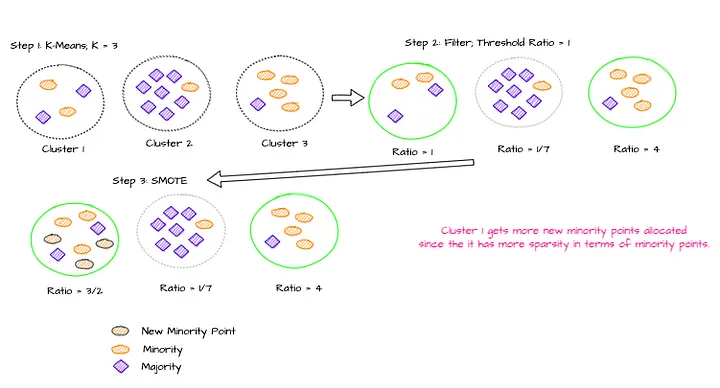

Do K-Means Clustering on the data.

Select clusters that have a high proportion (>50% or user-defined) of minority class samples.

Apply conventional SMOTE to these selected clusters. Each cluster will be assigned new synthetic points. The number of these generated points will depend on the sparsity of the minority class in the cluster; the more the sparsity, the more new points.

## SVM SMOTE

SVM SMOTE [4] focuses on increasing minority points along the decision boundary. The argument behind this is that instances around this boundary are critical for estimating the optimal decision boundary (which contrasts with the K-Means method we saw earlier but aligns with the Borderline variant).

So this is how this method works:

Train an SVM on your data. This will give you the support vectors (we focus on the minority class support vectors).
We then use these support vectors to generate new samples. For each of the support vectors, we find its K-Nearest Neighbours and create samples along the line joining the support vector and the nearest neighbours using either interpolation or extrapolation.
If less than half of the nearest neighbours belong to the majority class, then we do extrapolation. This helps expand the minority class area towards the majority area. If not, we do interpolation. The idea here is that since the majority of the neighbours belong to the majority class, we’d instead consolidate the current area of the minority class.

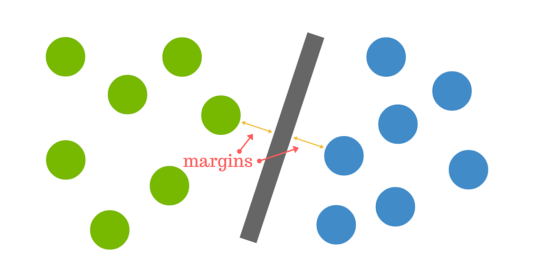

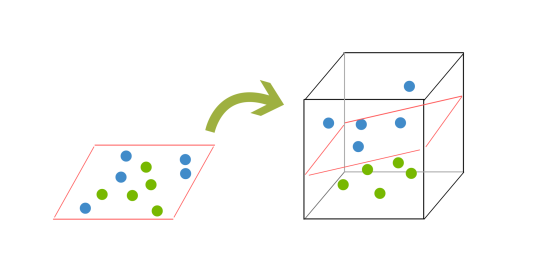

necessário converter o y

In [ ]:
# X =  df_model.drop('diabetes', axis=1)
# y = df_model['diabetes'].astype(np.uint8)

In [ ]:
# train_ratio = 0.7
# validation_ratio = 0.15
# test_ratio = 0.15

# # train é 75% do dataset
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state=SEED, shuffle=True)

# # test é 15% do dataset inicial
# # validation é 15% do dataset inicial
# X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=SEED, shuffle=True)

In [ ]:
# from imblearn.over_sampling import SVMSMOTE
# y_train = y_train.astype(np.uint8)
# smote =SVMSMOTE(random_state = SEED)
# # Upsample the minority class using SMOTE
# X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# print("Distribuição de diabéticos antes do SMOTE:")
# print(y_train.value_counts())

# print("Distribuição de diabéticos depois do SMOTE:")
# print(y_resampled.value_counts())

In [ ]:
# # Perform PCA for dimensionality reduction and visualization
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X)
# X_resampled_pca = pca.transform(X_resampled)

# # Plot the data before and after SMOTE
# plt.figure(figsize=(12, 6))

# plt.subplot(1, 2, 1)
# plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='bwr', alpha=0.7)
# plt.title('Dados antes do SMOTE')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.legend(handles=[plt.Line2D([], [], color='blue', marker='o', linestyle='None', alpha=0.7, label='Sem diabetes'),
#                     plt.Line2D([], [], color='red', marker='o', linestyle='None', alpha=0.7, label='Com diabetes')])

# plt.subplot(1, 2, 2)
# plt.scatter(X_resampled_pca[:, 0], X_resampled_pca[:, 1], c=y_resampled, cmap='bwr', alpha=0.7)
# plt.title('Dados depois do SMOTE')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.legend(handles=[plt.Line2D([], [], color='blue', marker='o', linestyle='None', alpha=0.7, label='Sem diabetes'),
#                     plt.Line2D([], [], color='red', marker='o', linestyle='None', alpha=0.7, label='Com diabetes')])

# plt.tight_layout()
# plt.show()

In [ ]:
# # x agora é o resampled
# X_train= X_resampled.copy()
# y_train = y_resampled.copy()

treinado com o modelo tunado pelo ADASYN, fazer grid search aqui também

In [ ]:
# model, X_val,y_pred, y_val = train_model(X_train, X_val, y_train, y_val,grid_search =False,model='tunedadasys')

In [ ]:
# print_classification_report(y_val, y_pred)

## Borderline SMOTE

In [ ]:
X =  df_model.drop('diabetes', axis=1)
y = df_model['diabetes']

In [ ]:
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

# train é 75% do dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state=SEED, shuffle=True)

# test é 15% do dataset inicial
# validation é 15% do dataset inicial
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=SEED, shuffle=True)

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE

smote = BorderlineSMOTE(random_state = SEED, kind = 'borderline-2')
# Upsample the minority class using SMOTE
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print("Distribuição de diabéticos antes do SMOTE:")
print(y_train.value_counts())

print("Distribuição de diabéticos depois do SMOTE:")
print(y_resampled.value_counts())

In [ ]:
# x agora é o resampled
X_train= X_resampled.copy()
y_train = y_resampled.copy()

treinado com o modelo tunado pelo outro SMOTE, fazer grid search aqui também

In [ ]:
model, X_val,y_pred, y_val = train_model(X_train, X_val, y_train, y_val,grid_search =False,model='tunedsmote')

In [ ]:
print_classification_report(y_val, y_pred)

## Downsample

In [ ]:
X =  df_model.drop('diabetes', axis=1)
y = df_model['diabetes']

In [ ]:
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

# train é 75% do dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state=SEED, shuffle=True)

# test é 15% do dataset inicial
# validation é 15% do dataset inicial
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=SEED, shuffle=True)

In [ ]:
df

In [ ]:
# Concatenate X_train and y_train
df = pd.concat([X_train, y_train], axis=1)

# Count the occurrences of each class
class_counts = df['diabetes'].value_counts()

# Find the minority class label and its count
minority_class_label = class_counts.idxmin()
minority_class_count = class_counts.min()

# Downsampling the majority classes
df_downsampled = pd.concat([
    resample(df[df['diabetes'] == minority_class_label],
             replace=False,  # Set to True if you want to allow repeated samples from the minority class
             n_samples=minority_class_count),
    *[resample(df[df['diabetes'] == label], replace=False, n_samples=minority_class_count) for label in class_counts.index if label != minority_class_label]
])

# Separate X_train and y_train after downsampling
X_train_downsampled = df_downsampled.iloc[:, :-1]
y_train_downsampled = df_downsampled.iloc[:, -1]



In [ ]:
# Print the downsampled datasets
print("X_train_downsampled:")
print(len(X_train_downsampled))
print("\ny_train_downsampled:")
print(len(y_train_downsampled))

In [ ]:
y_train_downsampled

In [ ]:
# x agora é o resampled
X_train= X_train_downsampled.copy()
y_train = y_train_downsampled.copy()

In [ ]:
model, X_val,y_pred, y_val = train_model(X_train, X_val, y_train, y_val,grid_search =False,model='tunedsmote')

In [ ]:
print_classification_report(y_val, y_pred)

# Tarefas



1.   Implementar gridsearch/optuna
2.   Tentar modelo mais pesado
3.   Alterar features? juntar exercício em algo em uma categoria só e comparar
4.   Critérios para a divisão de dados, pro smote e pro train test split, aplicar cross validation
5.   Colocar outras formas de avaliação do modelo, curva ROC e interpretar resultados
6.   Mostrar os modelos de forma explicável, arquitetura da árvore

Obs: o ideal é que todos dividam os dados da mesma forma e melhorem o baseline sem nunca observar o teste, para evitar vieses na construção do modelo

Minhas:

*   Plotar os casos FN E FP pra entender quais está errando
*   Colocar as opções de balanceamento dentro da de treinar modelo e deixar as funções menores e mais separadas
*   Entender como dividir os dados de forma equivalente, e validar se não é via balanceamento mesmo





opção: colocar a saída do PCA como entrada do modelo. paper: https://dergipark.org.tr/en/download/article-file/1777398

estudar: https://www.sciencedirect.com/topics/computer-science/false-negative

## teste de gpu

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

# referências antigas

In [ ]:
# import pdb
# pdb.set_trace()
# import sys
# !kill -9 -1
stopp

In [ ]:
# normalização

# Criando um objeto scaler
scaler = MinMaxScaler()

# Selecionando as colunas para normalização
cols_to_normalize = ['imc','peso']

# Aplicando a normalização min-max nas colunas selecionadas
df_ada[cols_to_normalize] = scaler.fit_transform(df_ada[cols_to_normalize])

In [ ]:
df_ada

In [ ]:
# Vamos primeiro separar as variáveis independentes (features) da variável dependente (target):
X = df_ada.drop('diabetes', axis=1)
y = df_ada['diabetes']

In [ ]:
def train_model(X, y, model_type='logistic_regression', grid_search=False):
    # Dividindo os dados em treino, validação e teste
    train_ratio = 0.75
    validation_ratio = 0.15
    test_ratio = 0.10

    # train é 75% do dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state=42)

    # test é 10% do dataset inicial
    # validation é 10% do dataset inicial
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)

    print(X_train, X_val, X_test)
    if model_type == 'logistic_regression':
        # Criando o modelo de Regressão Logística
        model = LogisticRegression(random_state=42)
        params = {'penalty': ['l1', 'l2'], 'C': [0.1, 1, 10]}
    elif model_type == 'random_forest':
        # Criando o modelo de Random Forest
        model = RandomForestClassifier(random_state=42,max_depth=15)
        params = {'n_estimators': [100, 300, 500], 'max_depth': [5, 10,15, 20], 'min_samples_leaf': [1, 3, 5]}

    if grid_search:
        # Definindo os parâmetros para busca
        grid_search_cv = GridSearchCV(model, params, scoring='accuracy', cv=5, n_jobs=-1)

        # Treinando o modelo com a busca em grid
        grid_search_cv.fit(X_train, y_train)

        # Selecionando o melhor modelo encontrado na busca em grid
        model = grid_search_cv.best_estimator_

    # Treinando o modelo nos dados de treino
    model.fit(X_train, y_train)

    # Avaliando o modelo nos dados de validação
    y_pred = model.predict(X_val)

    return model, X_val, X_test, y_val,y_pred, y_test

In [ ]:
def print_classification_report(y_val, y_val_pred):
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_balanced_accuracy = balanced_accuracy_score(y_val, y_val_pred)
    print("Acurácia na validação: {:.2f}%".format(val_accuracy * 100))
    print("Acurácia balanceada na validação: {:.2f}%".format(val_balanced_accuracy * 100))

    # Gerando o relatório com diversas métricas
    report = classification_report(y_val, y_val_pred)

    # Exibindo o relatório
    print(report)

    # Plotando a matriz de confusão
    matriz_confusão = confusion_matrix(y_val, y_val_pred)
    sns.heatmap(matriz_confusão, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.show()
    plt.close()


In [ ]:
model, X_val, X_test, y_val,y_pred, y_test = train_model(X, y)

In [ ]:
print_classification_report(y_val, y_pred)

In [ ]:
print(f'\n os pesos do modelo são:{model.coef_[0]} e o bias é {model.intercept_[0]}')

Balanceamento de classes

In [ ]:

# Separando as classes majoritária e minoritária
df_majority = df_ada[df_ada['diabetes'] == 0]
df_minority = df_ada[df_ada['diabetes'] == 1]

# Fazendo o downsample da classe majoritária
df_majority_downsampled = resample(df_majority, replace=False, n_samples=df_minority.shape[0], random_state=42)

# Concatenando as classes majoritária e minoritária
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Separando os dados de entrada (X) e a variável a ser prevista (y)
X = df_downsampled.drop('diabetes', axis=1)
y = df_downsampled['diabetes']

In [ ]:
# ax = sns.countplot(df_downsampled['diabetes'])
# for p in ax.patches:
#    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))

In [ ]:
model, X_val, X_test, y_val,y_pred, y_test = train_model(X, y)
print("Parâmetros do modelo :")
print(model.get_params())

In [ ]:
print_classification_report(y_val, y_pred)

In [ ]:
model, X_val, X_test, y_val,y_pred, y_test = train_model(X, y,model_type = 'random_forest',grid_search=False)
print_classification_report(y_val, y_pred)
print(model.get_params())


In [ ]:
print(f'\n os pesos do modelo são:{model.feature_importances_} ')

In [ ]:
# random forest, com gridsearch demora uns 5 minutos

tic = time.perf_counter()
model, X_val, X_test, y_val,y_pred, y_test = train_model(X, y,model_type = 'random_forest',grid_search=True)
toc = time.perf_counter()
print_classification_report(y_val, y_pred)
print(model.get_params())

In [ ]:
time_train = toc-tic
print(f"Modelo treinado em {time_train/60:0.4f} minutos")

In [ ]:
df_ada

In [ ]:
print(f'\n os pesos do modelo são:{model.feature_importances_} ')